<a href="https://colab.research.google.com/github/neven-x/Social-Hierarchy-RL/blob/main/RL_Social_Hierarchy_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [403]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

import gym
from gym import spaces

import functools
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.optimizers import Adam

from pettingzoo.utils.env import ParallelEnv

from tqdm import tqdm


In [415]:
class Hierarchy_Grid(ParallelEnv):
    metadata = {
        "name": "Hierarchy Grid",
    }

    def __init__(self, grid_size, num_agents, max_iter):
        self.timestep = None
        self.grid_size = grid_size
        self.possible_agents = np.arange(num_agents)
        self.agents = np.arange(num_agents)
        self.max_iter = max_iter
        self.agent_positions = None
        self.food_positions = None
        self.fight_probs = {name: np.zeros(self.num_agents) for name in self.agents}
        self.rewards = {name: 0 for name in self.agents}

        self.observation_space = spaces.MultiDiscrete([self.grid_size, self.grid_size, self.num_agents + 1])
        self.action_space = spaces.Discrete(5)

        self.food_position_map = np.zeros((self.grid_size, self.grid_size))
        self.agent_position_maps = {}

    def reset(self):
        self.timestep = 0

        self.agent_positions = {}
        self.agent_position_maps = {}
        for agent in self.agents:

            agent_position = np.random.randint(0, self.grid_size, 2)
            self.agent_positions[agent] = agent_position

            agent_position_map = np.zeros((self.grid_size, self.grid_size))
            agent_position_map[agent_position[0], agent_position[1]] = 1
            self.agent_position_maps[agent] = agent_position_map

        self.food_positions = []
        self.food_position_map = np.zeros((self.grid_size, self.grid_size))
        for n in range(6):

            new_tile = np.random.randint(0, self.grid_size, 2)
            self.food_positions.append(new_tile)
            self.food_position_map[new_tile[0], new_tile[1]] += 1

        observations = np.stack(self.agent_position_maps.values())
        observations = np.concatenate([observations, np.expand_dims(self.food_position_map, axis=-1)], axis=-1)
        observations = np.expand_dims(observations, axis=0)

        observations = {name: observations for name in self.agents}
        return observations, {}

    def step(self, actions):

        self.timestep += 1
        self.rewards = {name: 0 for name in self.agents}

        for agent in self.agents:
            action = actions[agent]
            self.move_agent(agent, action)

        self.several_on_food_tile()

        if self.timestep > self.max_iter:
            terminations = {name: True for name in self.agents}
        else:
            terminations = {name: False for name in self.agents}

        observations = np.stack(self.agent_position_maps.values())
        observations = np.concatenate([observations, np.expand_dims(self.food_position_map, axis=-1)], axis=-1)
        observations = np.expand_dims(observations, axis=0)

        observations = {name: observations for name in self.agents}

        return observations, self.rewards, terminations, _, {}


    def move_agent(self, agent, action):
        # Move the agent based on the selected action
        x, y = self.agent_positions[agent]

        if action == 0:  # Up
            x -= 1
        elif action == 1:  # Down
            x += 1
        elif action == 2:  # Left
            y -= 1
        elif action == 3:  # Right
            y += 1
        elif action == 4:  # Stay
            pass

        # Check if the new position is within grid boundaries
        if 0 <= x < self.grid_size and 0 <= y < self.grid_size:
            self.agent_positions[agent] = (x, y)

            new_map = np.zeros((self.grid_size, self.grid_size))
            new_map[x, y] = 1
            self.agent_position_maps[agent] = new_map


    def conflict(self, agent1, agent2):

        print(f"Conflict happened between agents {agent1}, {agent2}")

        def sig(x):
            return 1 / (1 + np.exp(-x))

        # Agents make decision to fight or leave
        # 1 == fight, 0 == leave
        decision1 = bool(np.random.binomial(1, sig(self.fight_probs[agent1][agent2])))
        decision2 = bool(np.random.binomial(1, sig(self.fight_probs[agent2][agent1])))

        # Outcome of fight is determined in case both decide to stay
        outcome = np.random.binomial(1, 0.5)
        if outcome == 0:
            outcome = -1

        if not (decision1):
            self.relocate_agent(agent1)
        if not (decision2):
            self.relocate_agent(agent2)

        reward_dict = {(False, False): (0, 0),
                       (True, False): (5, 0),
                       (False, True): (0, 5),
                       (True, True): (5 * outcome, 5 * np.delete([-1,1], outcome))}

        # Allocate rewards based on decisions and fight outcome
        reward1, reward2 = reward_dict[(decision1, decision2)]
        self.rewards[agent1] += reward1
        self.rewards[agent2] += reward2

        # Update future staying probabilities
        lr = 0.01
        self.fight_probs[agent1][agent2] += lr * reward1 * (decision1 - sig(self.fight_probs[agent1][agent2]))
        self.fight_probs[agent2][agent1] += lr * reward2 * (decision2 - sig(self.fight_probs[agent2][agent1]))

    def several_on_food_tile(self):

        for food_tile in self.food_positions:
            agents_on_tile = [agent for agent, position in self.agent_positions.items() if (position == food_tile).all()]

        if len(agents_on_tile) > 1:

            pairs = zip(agents_on_tile[:-1], agents_on_tile[1:])

            for pair in pairs:
                
                self.conflict(pair[0], pair[1])

        if len(agents_on_tile) == 1:
            self.rewards[agents_on_tile[0]] += 5


    def relocate_agent(self, agent):
        # Relocate the agent to an adjacent position
        agent_position = self.agent_positions[agent]

        valid_position = False
        step = 1
        while not valid_position:

            # Generate moves
            possible_moves = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]]) * step  # Right, Left, Down, Up

            # Check if any of new positions are valid (within gridworld and not already occupied)
            for move in possible_moves:
                new_position = tuple(map(sum, zip(agent_position, move)))

                if 0 <= new_position[0] < self.grid_size and 0 <= new_position[1] < self.grid_size:
                    if np.isin((1,2), list(env.agent_positions.values())).any():

                        valid_position = True
                        self.agent_positions[agent] = new_position
                        agent_position_map = np.zeros((self.grid_size, self.grid_size))
                        agent_position_map[new_position] = 1
                        self.agent_position_maps[agent] = agent_position_map

            step += 1

    def render(self):

        fig = plt.figure(figsize=(5,5), frameon=False)

        plt.title("Grid World",size=13)
        plt.xticks(np.arange(0,self.grid_size,1))
        plt.yticks(np.arange(0,self.grid_size,1))

        agent_position_map = sum(self.agent_position_maps.values())

        plt.imshow(self.food_position_map, vmax = 2, cmap = 'Greens', alpha=0.4, extent=[0, 10, 0, 10])
        plt.imshow(agent_position_map, vmax = 2, cmap = 'Reds', alpha=0.4, extent=[0, 10, 0, 10])

        ax = plt.gca();
        ax.grid()

        plt.show()

gym.register(
    id='Hierarchy_Grid',
    entry_point=Hierarchy_Grid,
    kwargs={'grid_size': 10, 'num_agents': 10, 'max_iter': 1000}
)

env = gym.make('Hierarchy_Grid')

In [416]:
class DQNAgent:
    def __init__(self, state_shape, action_size):
        self.state_shape = state_shape
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', name='Conv1', input_shape=self.state_shape))
        model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', name='Conv2'))
        model.add(MaxPool2D(name='MaxPool'))
        model.add(Flatten(name='Flatten'))
        model.add(Dense(128, activation='relu', name='Dense'))
        model.add(Dense(self.action_size, activation='linear', name='output'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):  # action selection, epsilon-greedy.
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def update(self, state, action, reward, next_state):
        target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
        target_f = self.model.predict(state)
        target_f[0][action] = target
        self.model.fit(state, target_f, epochs=1, verbose=0)

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


In [417]:
env = gym.make('Hierarchy_Grid')
n_actions = env.action_space.n
state_shape = env.observation_space
max_time = 30

returns = {name: 0 for name in range(env.num_agents)}

Np = env.num_agents
players = []
for i in range(Np):
    players.append(DQNAgent((10, 10, 11), n_actions))

# initial state, maybe we don't want to reset the fight probs
Neps = 1

# ---- model training/visualization loop
for eps in tqdm(range(Neps)):
    state, _ = env.reset()
    done = False
    timestep = 0
    while timestep < max_time:
        print(timestep)
        action = []
        # get actions of all agents
        for p in range(Np):
            action.append(players[p].act(state[p]))
        next_state, reward, terminations, _, _ = env.step(action)  # we need reward to be a list of size Np

        # Update returns
        for agent in range(Np):
            returns[agent] += reward[agent]

        '''for agent in range(Np):  # the DQN should also be updated in each step
            players[p].remember(state[agent], action[agent], reward[agent], next_state, done)'''

        for p in range(Np):
            # train the model in each step
            players[p].update(state[agent], action[p], reward[p], next_state[agent])
            state = next_state

        timestep += 1

    # train the model by replay, leverages memory
    '''batch_size = 32  # try a larger batch size for better stability and efficiency
    for p in range(Np):
        players[p].replay(batch_size)'''

state, _ = env.reset()  # Reset the environment at the start of each episode

  0%|          | 0/1 [00:00<?, ?it/s]

0
1/1 [==============================] - 0s 8ms/step
1
1/1 [==============================] - 0s 8ms/step
2
1/1 [==============================] - 0s 8ms/step
3
1/1 [==============================] - 0s 8ms/step
4
1/1 [==============================] - 0s 8ms/step
5
1/1 [==============================] - 0s 8ms/step
6
1/1 [==============================] - 0s 9ms/step
7
1/1 [==============================] - 0s 9ms/step
8
1/1 [==============================] - 0s 8ms/step
9
1/1 [==============================] - 0s 9ms/step
10
1/1 [==============================] - 0s 8ms/step
11
1/1 [==============================] - 0s 8ms/step
12
1/1 [==============================] - 0s 8ms/step
13
1/1 [==============================] - 0s 7ms/step
14
1/1 [==============================] - 0s 8ms/step
15
1/1 [==============================] - 0s 9ms/step
16
1/1 [==============================] - 0s 9ms/step
17
1/1 [==============================] - 0s 8ms/step
18
Conflict happened between agents 1,

  0%|          | 0/1 [01:01<?, ?it/s]


KeyboardInterrupt: 

Text(0, 0.5, 'Total return')

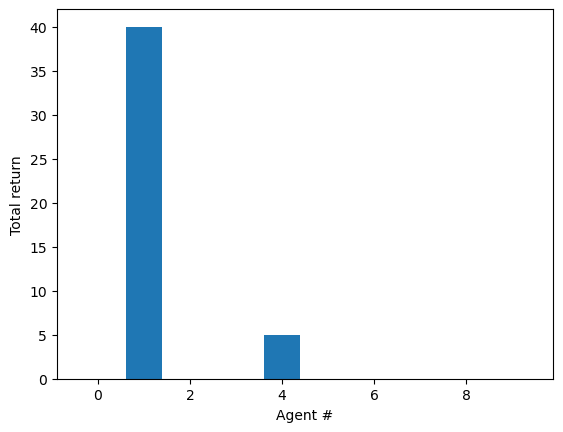

In [418]:
plt.bar(np.arange(10), list(returns.values()))
plt.xlabel('Agent #')
plt.ylabel('Total return')

In [419]:
env.fight_probs

{0: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 1: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 2: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 3: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 4: array([0.   , 0.025, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 5: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 6: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 7: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 8: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 9: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

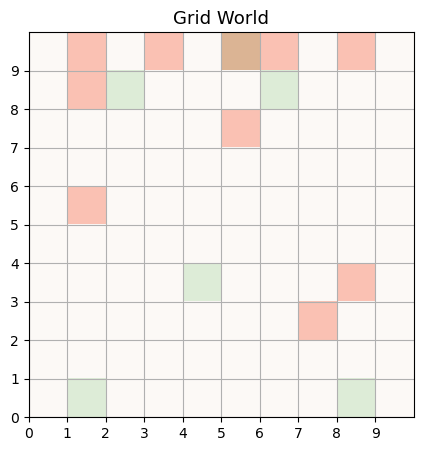

In [374]:
action = []
# get actions of all agents
for p in range(Np):
    action.append(players[p].act(state))

state, reward, terminations, _, _ = env.step(action)

env.render()